# Figures for paper — now with diffusion mapping!

In [1]:
# Import modules and R
import numpy as np, pandas as pd
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

In [2]:
# Import local code
import sys
sys.path.append('../code')
from gradientVersion import *
from processing_helpers import *
from analysis_helpers import *
from triplets import *
from mri_maps import *
from enrichments import *
from brainspan import *
%R source("../code/Rplots.R");
%R source("../code/brainPlots.R");
%R source("../code/enrichmentsPlots.R");
%R source("../code/plot_maps.R");
%R source("../code/brainspanPlots.R");

/opt/conda/lib/python3.8/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


---

## Set gradient version

In [3]:
pca = gradientVersion(approach='pca').fit('hcp_base')
pca_hcp_3d_ds8 = gradientVersion(approach='pca').fit('hcp_3donors_ds8')
dm_hcp_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_ds9')
dm_hcp_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3donors_ds5')

New gradients version: method=pca, kernel=None, data=hcp_base
New gradients version: method=pca, kernel=None, data=hcp_3donors_ds8
New gradients version: method=dm, kernel=normalized_angle, data=hcp_ds9
New gradients version: method=dm, kernel=normalized_angle, data=hcp_3donors_ds5


In [4]:
hcp_version = dm_hcp_ds9

---

## 1 — Distributions

In [5]:
counts_hcp = pd.read_csv("../outputs/counts_hcp.csv", index_col=0)
stability = pd.read_csv("../outputs/stability_hcp_ranked.csv", index_col=0).set_index('gene_symbol')
donor_counts = (counts_hcp!=0).sum(axis=1)[:180].rename('count').to_frame()

In [6]:
stability['ds'].quantile(.9)

0.3859072493003411

## 1 — Gradients on brains

In [7]:
hcp_scores = (pd.concat({
    'PCA, all genes and regions': pca.clean_scores(flips=[1,2]),
    # 'PCA, top 80% DS genes,\nonly 3+ donor regions': pca_hcp_3d_ds8.clean_scores(flips=[]),
    'DM, only top 10% DS genes,\nall regions': dm_hcp_ds9.clean_scores(),
    'DM, top 50% DS genes,\nonly 3+ donor regions': dm_hcp_3d_ds5.clean_scores(flips=[]),
    # 'DM, only top 10% DS genes,\nall regions': dm_hcp_ds9.clean_scores(),
})
        .reset_index(level=0).rename({'level_0':'version'},axis=1)
         )

In [9]:
%%R -i hcp_scores -w 2000 -h 1000
# plot_hcp(hcp_scores, three=T) & theme(text=element_text(size=36))

NULL


## 1 — Triplets filtering

Load triplets data from pickles since triplets are slow to compute

In [8]:
triplets_hcp = load_pickle('triplets_hcp')
triplets_hcp_3donors = load_pickle('triplets_hcp_3donors')

In [9]:
triplets_pca = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='pca'), with_coefs=False)
triplets_dm = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)
triplets_dm_3d = make_triplet_ds_plot(get_triplets_ds_levels(triplets_hcp_3donors, use_gradientVersion=True, approach='dm', kernel='normalized_angle', alpha=1), with_coefs=False)

In [10]:
triplets_dict = {
    'PCA': triplets_pca, 
    'Diffusion Maps (DM)': triplets_dm,
    # 'Diffusion Map, 2+ donors/region': triplets_dm_2d,
    'DM, only 3+ donors regions': triplets_dm_3d
}

triplets_plot_v2 = (pd.concat(triplets_dict)
 .reset_index(0)
 .rename({'level_0':'method', 'version':'DS'}, axis=1)
 .assign(method = lambda x: pd.Categorical(x['method'], ordered=True, categories=triplets_dict.keys()))
                   )

df_triplets_highlight = pd.DataFrame({'method': triplets_dict.keys(), 'DS':[0,.9,.5]}).assign(method = lambda x: pd.Categorical(x['method'], ordered=True, categories=triplets_dict.keys()))

## 2 — Brainspan mapping

In [11]:
bs_cortex_mapping = get_bs_cortex_mapping()
hcp_bs_mapping = get_hcp_bs_mapping(bs_cortex_mapping)

In [12]:
bs_exp, bs_col, bs_row = get_brainspan()
bs_clean = clean_brainspan(bs_exp, bs_col, bs_row, bs_cortex_mapping)
bs_agg = aggregate_brainspan_by_age(bs_clean)

## 2 — Brainspan development

In [13]:
weights_version = dm_hcp_3d_ds5

In [14]:
scores_cortex = get_mapped_scores(weights_version, hcp_bs_mapping)
bs_scores = compute_brainspan_scores(bs_agg, weights_version, bs_cortex_mapping)

In [15]:
age_groups = get_age_groups()
bs_scores_corr = correlate_bs_scores(bs_scores, scores_cortex, age_groups=age_groups)

## 2 — Brainspan adult correlation

In [16]:
cortex_scores, cortex_corrs = get_cortex_scores(bs_scores, scores_cortex, age_groups, bs_cortex_mapping)

# Fig 1

Message: With careful processing, PC2 and PC3 of the AHBA are robust and generalizable.

In [26]:
%%R -w 20 -h 28 --units in -r 300 -i triplets_plot_v2 -i donor_counts -i stability -i hcp_scores -i df_triplets_highlight -i hcp_bs_mapping -i cortex_scores -i cortex_corrs
# %%R -w 2000 -h 2100 -i triplets_plot_v2 -i donor_counts -i stability -i hcp_scores -i df_triplets_highlight
source("../code/Rplots.R")
source("../code/brainspanPlots.R")
library(magick)

img <- image_read("../data/schematics/fig1_schem.png")

g0 <- image_ggplot(img)
g1a <- plot_ds_dist_hcp(stability)
g1b <- plot_dist_donors_hcp(donor_counts)
g2 <- plot_triplets_v2(triplets_plot_v2) + geom_vline(data=df_triplets_highlight, aes(xintercept=DS), size=10, alpha=.2, color='grey')
g3 <- plot_hcp(hcp_scores, three=T, switch='y') + theme(legend.position='right') + guides(fill=guide_colorbar(title='Score', barheight=10, title.hjust=0))

g4a <- plot_bs_mapping(hcp_bs_mapping)
g4b <- plot_ahba_bs_scatter(cortex_scores, cortex_corrs)

caption <- paste("**Figure 1:**",
                "**A**, Schematic of triplet method to ensure generalizability of AHBA gradients.",
                "**B**, Distribution of differential stability across AHBA donors of each gene's expression in the HCP-MMP1.0 parcellation.",
                "**C**, Distribution of how many AHBA donors are represented in each region of the HCP-MMP1.0 parcellation.",
                "**D**, Correlations of region scores vs % of top DS genes retained, between on independently processed triplets of the six AHBA donor brains, for PCA, DM, and DM when filtered for the 137/180 regions with samples from at least 3 of the 6 donors.",
                "**E**, Region scores of AHBA gradients in HCP-MMP1.0 parcellation using all six donors; for PCA with all genes, DM with only the top 10% of genes, and DM with the top 50% of genes for only the 137/180 regions with samples from at least 3 of the 6 donors.",
                "**F**, Sampled regions from the independent BrainSpan RNA-seq dataset, matched to the HCP-MMP1.0 parcellation.",
                "**G**, BrainSpan RNA-seq gene expression for adult brains (18-40 yrs) in matched regions scored with gene weights from AHBA gradients, vs AHBA gradient mean scores in the matched HCP regions."
)


layout <- c(
  # Schematic and distributions    
  area(t = 1, b = 2, l = 1, r = 5),
  area(t = 1, b = 1, l = 6, r = 6),
  area(t = 2, b = 2, l = 6, r = 6),
  # Triplets
  area(t = 3, b = 5, l = 1, r = 6),
  # Brain maps
  area(t = 6, b = 9, l = 1, r = 6),
  # Brainspan
  area(t = 10, b = 11, l = 1, r = 3),
  area(t = 10, b = 11, l = 4, r = 6) 

)
plot <- g0 + g1a + g1b + g2 + g3 + g4a + g4b + plot_layout(design = layout)

themed <- plot & theme(
    text=element_text(size=20), 
    strip.text=element_text(size=20),
    strip.text.x=element_text(size=20),
    strip.text.y=element_text(size=20),
    plot.margin = margin(t=10, r=10, b=10, l=10, "pt"),
    plot.tag = element_text(size=28, face='bold', vjust=-2)
)
    
annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 20, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated
# ggsave(filename='test2.png', device='png')

---

## 2 — Parcellations

In [88]:
dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')
dm_dx_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dx_ds9')

New gradients version: method=dm, kernel=normalized_angle, data=dk_ds9
New gradients version: method=dm, kernel=normalized_angle, data=dx_ds9


In [89]:
hcp_scores = dm_hcp_ds9.clean_scores().assign(version='HCP-MMP1.0,\ntop 10% DS genes')
dk_scores = dm_dk_ds9.clean_scores().assign(version='Desikan-Killiany,\ntop 10% DS genes')
dx_scores = dm_dx_ds9.clean_scores().assign(version='Desterieux,\ntop 10% DS genes')

## 2 — Parcellation gene weight corrs

In [91]:
corrs_dict = {
    'HCP-MMP1.0,\ntop 10% DS genes': correlate(dm_hcp_ds9.fit_weights(overwrite=False), weights_version.weights),
    'Desikan-Killiany,\ntop 10% DS genes': correlate(dm_dk_ds9.fit_weights(), weights_version.weights),
    'Desterieux,\ntop 10% DS genes': correlate(dm_dx_ds9.fit_weights(), weights_version.weights)
}

weight_corrs = (pd.concat(corrs_dict)
 .melt(ignore_index=False)
 .reset_index()
 .set_axis(['version','x','y','corr'], axis=1)
 .loc[lambda x: (x['x'] < 3) & (x['y'] < 3)]
 .replace({'x':{0:'G1',1:'G2',2:'G3'}, 'y':{0:'G1',1:'G2',2:'G3'}})
)

In [92]:
def count_gene_overlap(v1, v2):
    overlap = set(v1.weights.index).intersection(set(v2.weights.index))
    overlap_v1 = round(len(overlap)/len(v1.weights.index),2)*100
    overlap_v2 = round(len(overlap)/len(v2.weights.index),2)*100
    print(f'Overlap is {overlap_v1}% of v1 genes, {overlap_v2}% of v2 genes')
    
count_gene_overlap(dm_hcp_ds9, dm_dk_ds9)

Overlap is 85.0% of v1 genes, 85.0% of v2 genes


## 2 — Gene weight vs DS

In [94]:
stability = pd.read_csv("../outputs/stability_hcp_ranked.csv", index_col=0).set_index('gene_symbol')

weights_ds = (dm_hcp_3d_ds5.weights
            .iloc[:,:3].set_axis(['G1','G2','G3'],axis=1)
            .join(stability)
             )

# Fig 2

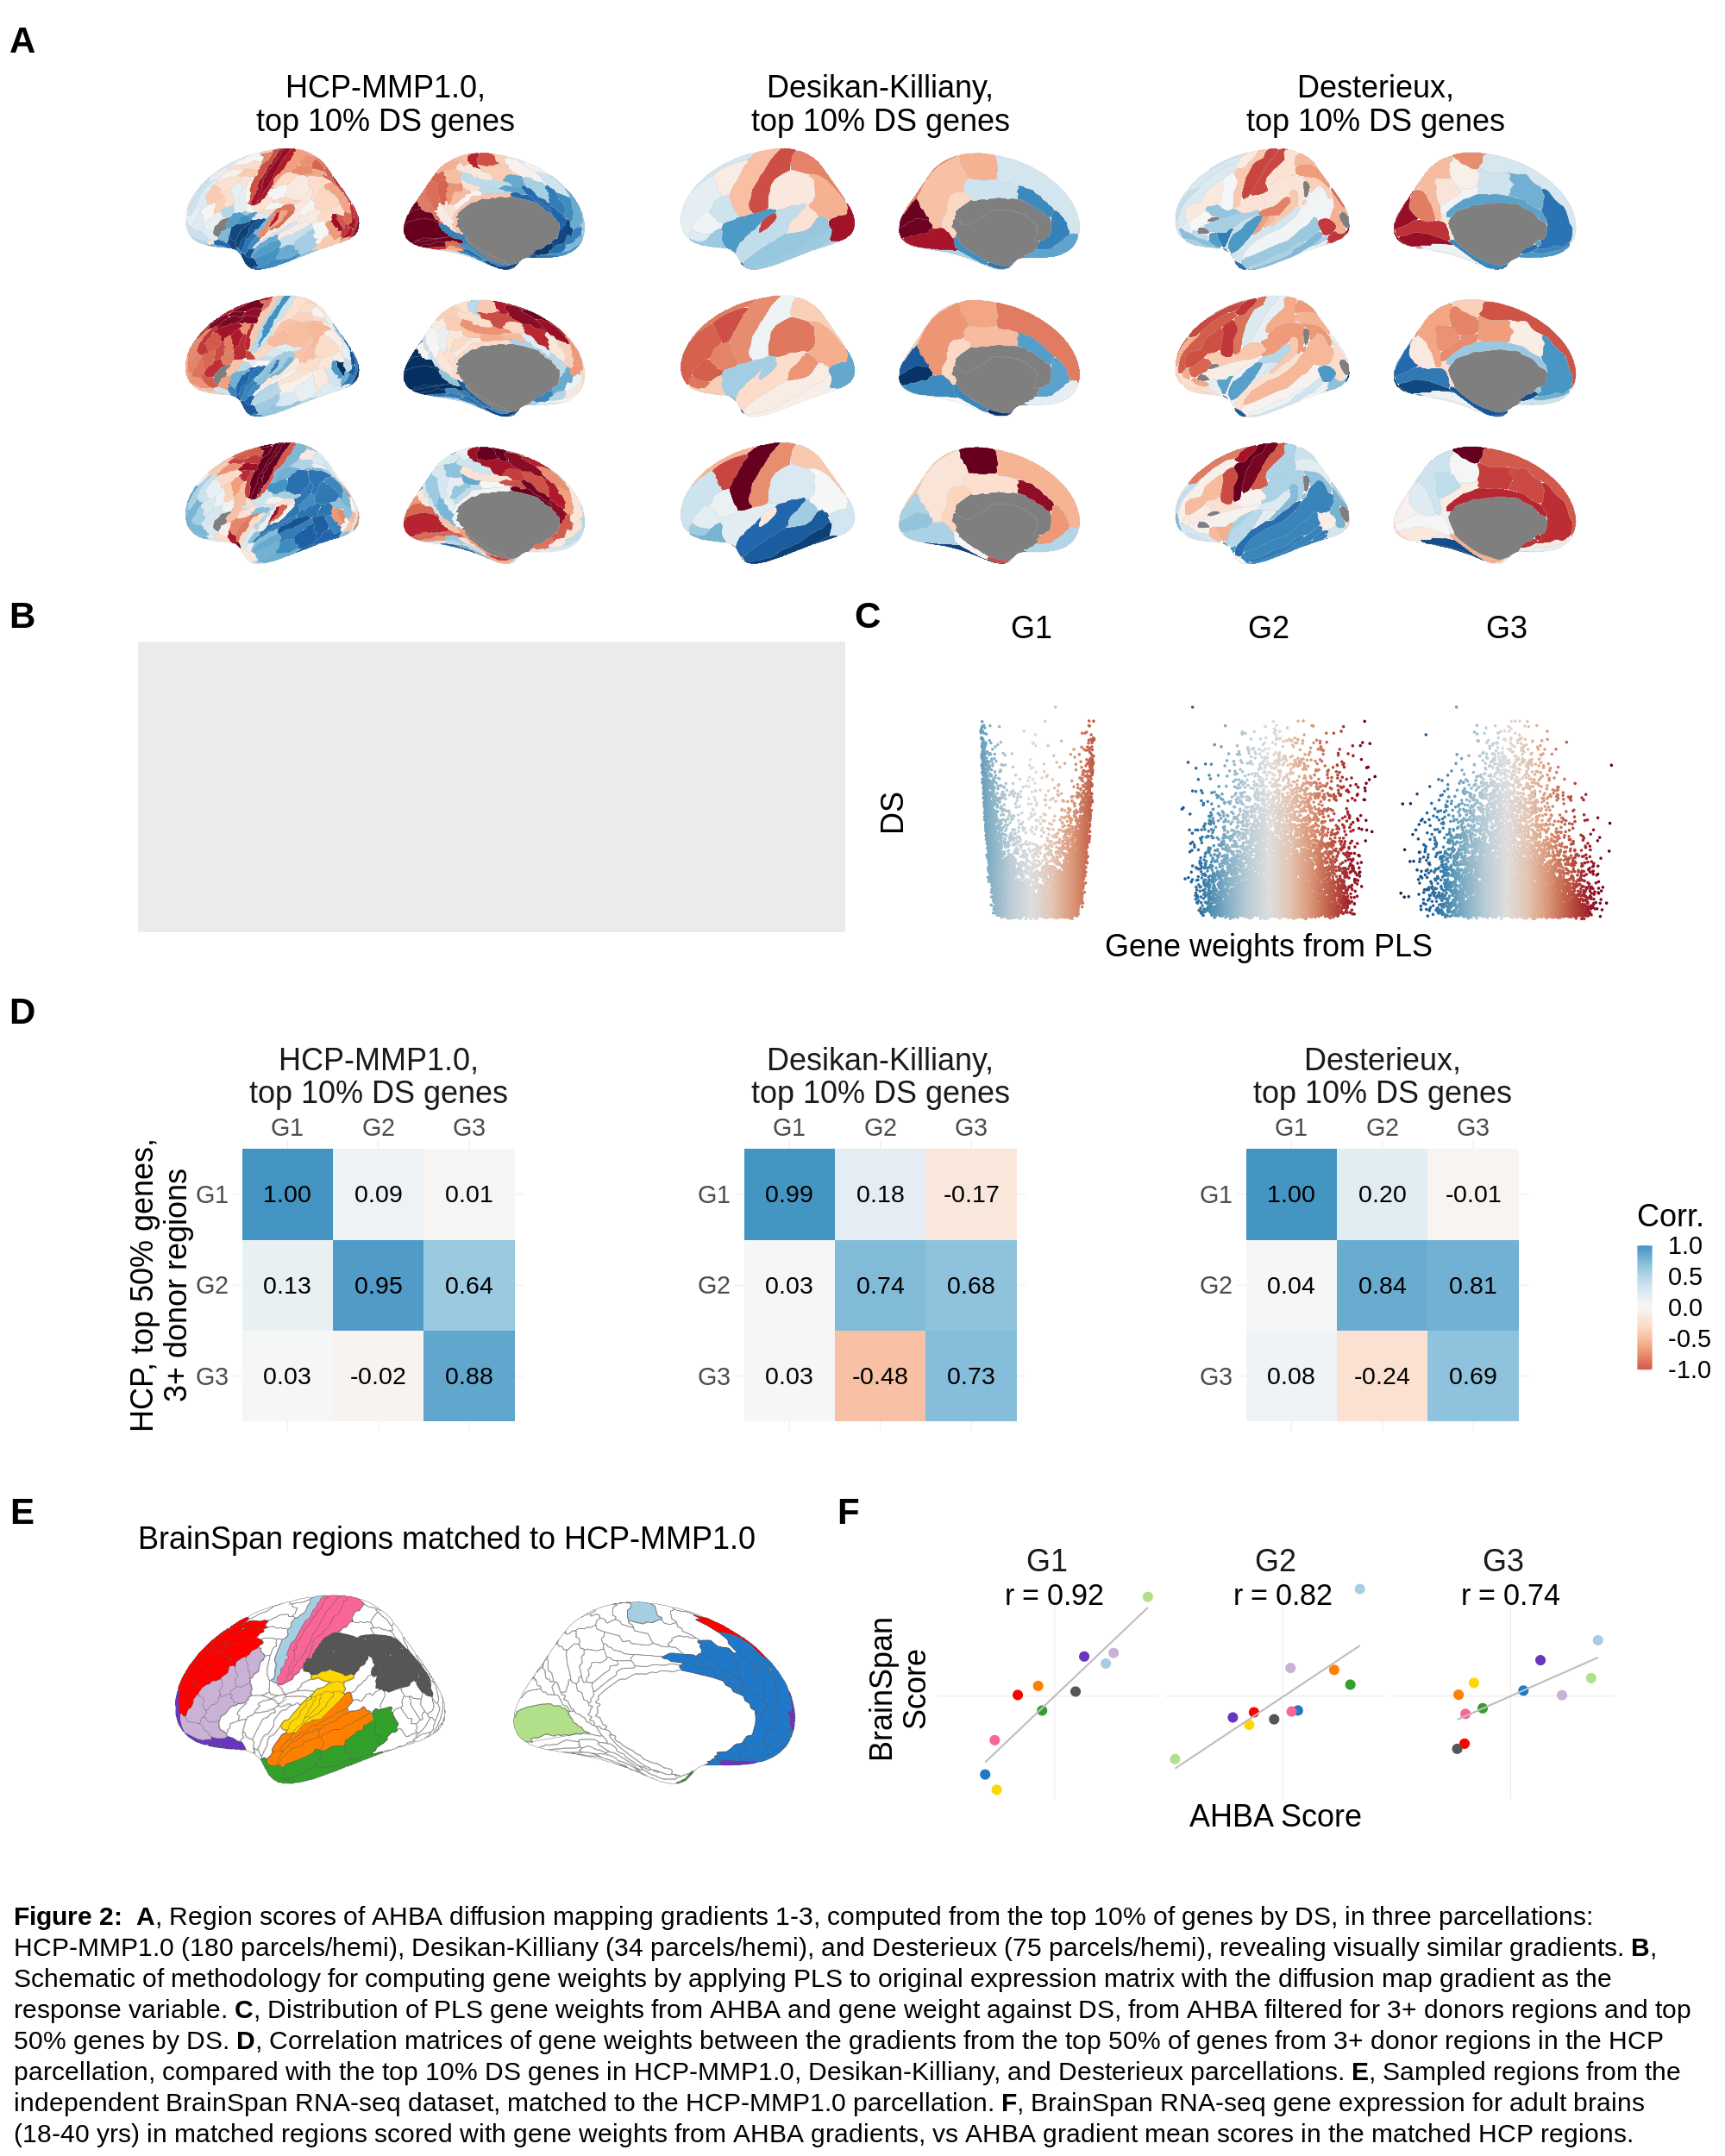

In [95]:
%%R -w 2000 -h 2500 -i hcp_scores -i dk_scores -i dx_scores -i weight_corrs -i bs_scores_corr -i cortex_scores -i cortex_corrs -i hcp_bs_mapping -i weights_ds
source("../code/Rplots.R")
source("../code/brainspanPlots.R")

g1a <- plot_hcp(hcp_scores, three=T)
g1b <- plot_dk(dk_scores, three=T) + plot_layout(tag_level='new')
g1c <- plot_dx(dx_scores, three=T) + plot_layout(tag_level='new')

g_img <- ggplot(data.frame())

g0 <- plot_weights_ds(weights_ds) + plot_layout(tag_level='new')
g0a <- plot_weights_dist(weights_ds)

g2 <- plot_weight_corrs(weight_corrs)

g3 <- plot_bs_mapping(hcp_bs_mapping)
g4 <- plot_ahba_bs_scatter(cortex_scores, cortex_corrs)


plot <- (
    # Row 1
    ((g1a | g1b | g1c) & theme(legend.position='none', strip.text.y=element_blank())) /
    # Row 2
    (g_img | ((g0a / (g0 )) + plot_layout(heights=c(1,5)))) /
    # Row 3
    g2 /
    # Row 4
    (g3 | g4) 
) + plot_layout(heights=c(3,2,2,2))


caption <- paste("**Figure 2:**",
                 "**A**, Region scores of AHBA diffusion mapping gradients 1-3, computed from the top 10% of genes by DS, in three parcellations: HCP-MMP1.0 (180 parcels/hemi), Desikan-Killiany (34 parcels/hemi), and Desterieux (75 parcels/hemi), revealing visually similar gradients.",
                 "**B**, Schematic of methodology for computing gene weights by applying PLS to original expression matrix with the diffusion map gradient as the response variable.",
                 "**C**, Distribution of PLS gene weights from AHBA and gene weight against DS, from AHBA filtered for 3+ donors regions and top 50% genes by DS.",
                 "**D**, Correlation matrices of gene weights between the gradients from the top 50% of genes from 3+ donor regions in the HCP parcellation, compared with the top 10% DS genes in HCP-MMP1.0, Desikan-Killiany, and Desterieux parcellations.",
                 "**E**, Sampled regions from the independent BrainSpan RNA-seq dataset, matched to the HCP-MMP1.0 parcellation.",
                 "**F**, BrainSpan RNA-seq gene expression for adult brains (18-40 yrs) in matched regions scored with gene weights from AHBA gradients, vs AHBA gradient mean scores in the matched HCP regions."
                )

themed <- plot & theme(
    text=element_text(size=36), 
    strip.text = element_text(size=36),
    plot.tag = element_text(size=42, face='bold', vjust=-2))
annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

---

# Fig 3 — Gene enrichments

## 3 — Cell enrichments

In [76]:
cell_genes = get_cell_genes()
weights_version = dm_hcp_3d_ds5
weights_version.fit_weights(normalize=False);

weights = weights_version.weights.iloc[:,:3]
gene_masks = match_cell_genes(cell_genes, weights)
nulls = shuffle_gene_weights(weights, n=10000, rank=False)

In [77]:
gene_masks = match_cell_genes(cell_genes, weights)

In [78]:
true_scores, null_scores = compute_cell_scores(
    weights, nulls, gene_masks, how='mean')

cell_null_p = compute_null_p(true_scores, null_scores, adjust='fdr_bh')

## 3 — STRING enrichments

In [122]:
enrichments_keywords = combine_enrichments('dm_hcp_3d_ds5', 'Keyword', include_g1=False)
enrichments_process = combine_enrichments('dm_hcp_3d_ds5', 'Process', include_g1=False)

In [152]:
hcp_scores_single = dm_hcp_ds9.clean_scores(flips=[]).assign(version='')

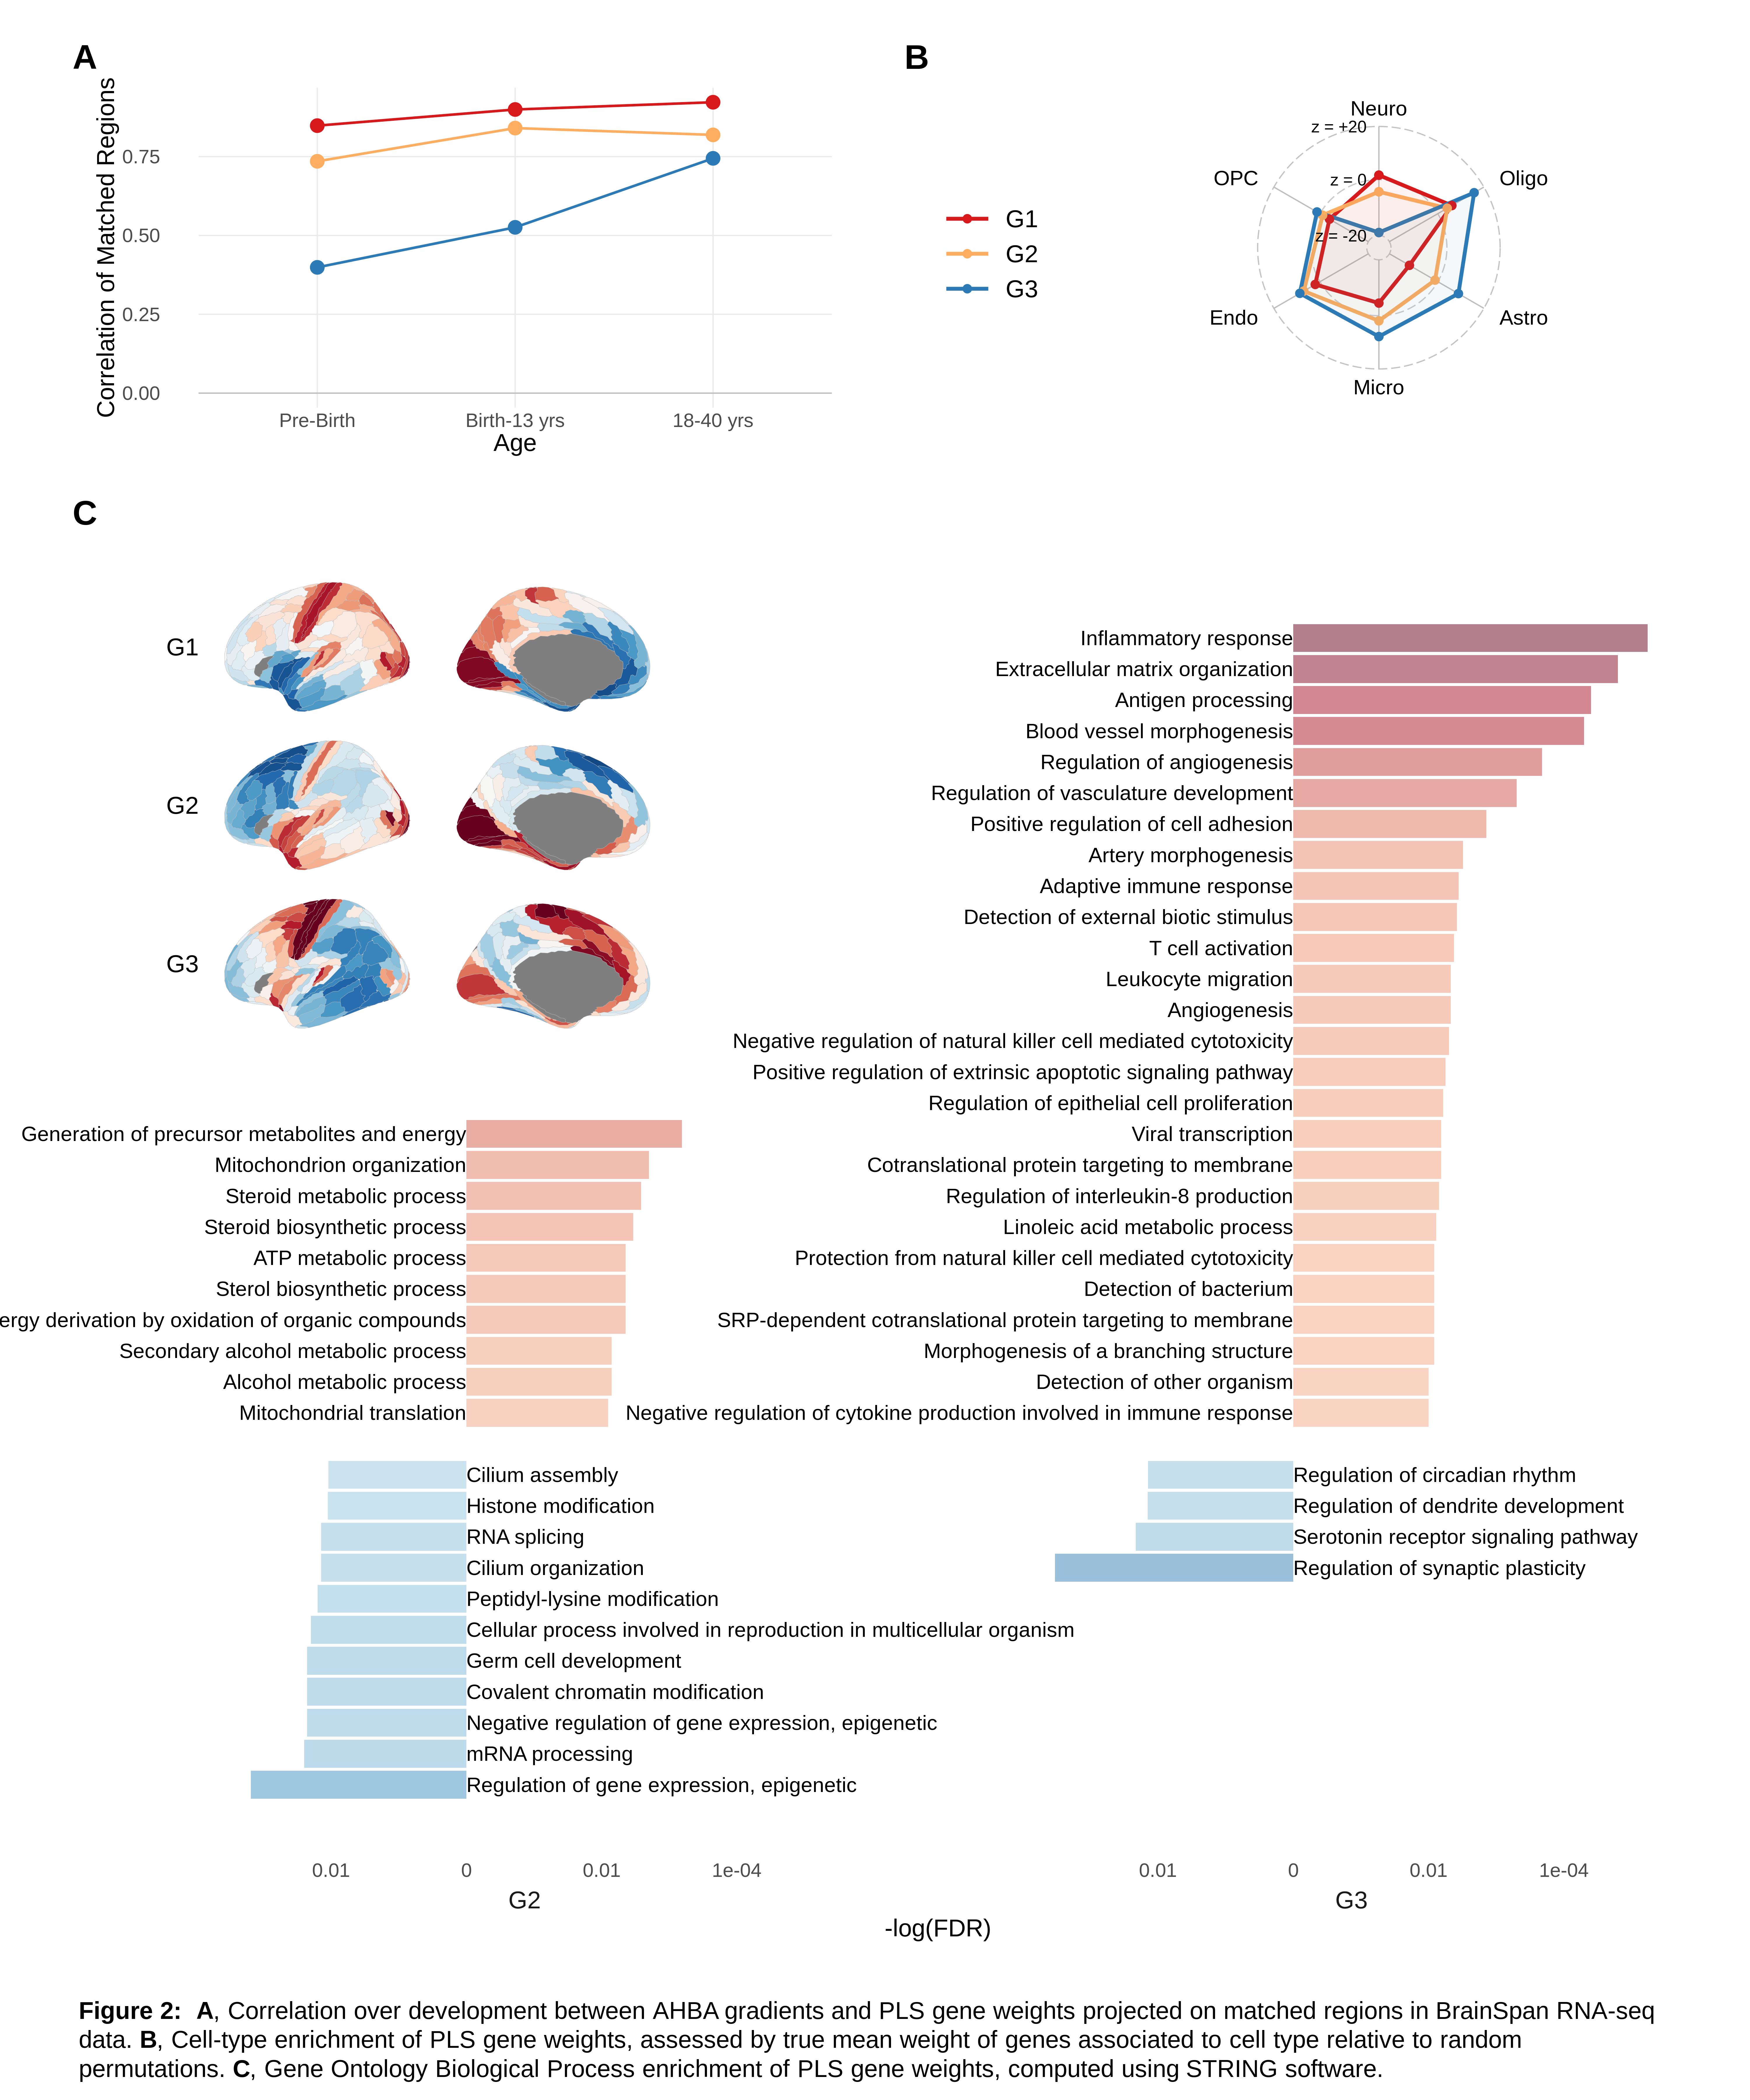

In [155]:
%%R -w 20 -h 24 --units in -r 300 -i hcp_scores_single -i bs_scores_corr -i cell_null_p -i enrichments_process -i enrichments_keywords
source("../code/enrichmentsPlots.R")
source("../code/brainspanPlots.R")

g0 <- plot_hcp(hcp_scores_single, switch='y') + guides(fill='none') + plot_layout(tag_level='new')
g1 <- plot_bs_scores_corr(bs_scores_corr)
g2 <- plot_cell_radar(cell_null_p, size=6)
# g2 <- plot_cell_dotplot(null_p)

g3 <- plot_enrichments(enrichments_process, size=6)
# g3 <- plot_enrichments(enrichments_keywords, n=15, facet='h')


layout <- c(
  area(t = 1, b = 4, l = 1, r = 5),
  area(t = 1, b = 4, l = 6, r = 10),
  area(t = 5, b = 20, l = 1, r = 10),
  area(t = 5, b = 10, l = 1, r = 4)
  # area(t = 3, l = 1, b = 5, r = 6),
  # area(t = 6, l = 1, b = 8, r = 6)
)

plot <- g1 + g2 + g3 + g0 + plot_layout(design=layout)

themed <- plot & theme(
    text=element_text(size=20),
    strip.text=element_text(size=20),
    plot.margin = margin(t=10, r=30, b=10, l=30, "pt"),
    plot.tag = element_text(size=28, face='bold', vjust=-2)
)

caption <- paste("**Figure 2:**",
                 "**A**, Correlation over development between AHBA gradients and PLS gene weights projected on matched regions in BrainSpan RNA-seq data.",
                 "**B**, Cell-type enrichment of PLS gene weights, assessed by true mean weight of genes associated to cell type relative to random permutations.",
                 "**C**, Gene Ontology Biological Process enrichment of PLS gene weights, computed using STRING software."
)

annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 20, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated

---

# Fig 4 — Maps

## MRI maps

In [187]:
maps = get_maps()#.drop(['Size Variation (allometric scaling)', 'fMRI PC1', 'NeuroSynth PC1'], axis=1)
null_corrs_dict = load_pickle('null_corrs_dict')

In [188]:
hcp_scores = dm_hcp_ds9.clean_scores().iloc[:,:3].rename_axis('region')
corrs = get_corrs(hcp_scores, maps, atlas='hcp')
null_corrs = null_corrs_dict['sim_grads_p']

mri_corrs = get_null_p(corrs, null_corrs, adjust='fdr_bh').assign(version='')

## Disorder maps

In [45]:
dm_dk_ds9 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('dk_ds9')

New gradients version: method=dm, kernel=normalized_angle, data=dk_ds9


In [189]:
maps = get_disorder_maps().drop(['ADHD', 'ANX', 'MCI'], axis=1)
null_corrs_dict_disorders = load_pickle('null_corrs_dict_disorders')

In [190]:
dk_scores = dm_dk_ds9.clean_scores().iloc[:,:3].rename_axis('region')
corrs = get_corrs(dk_scores, maps, atlas='dk')
null_corrs = null_corrs_dict_disorders['sim_grads_p']

disorder_corrs = get_null_p(corrs, null_corrs, adjust='fdr_bh').assign(version='')

## For plotting brains

In [96]:
maps_to_plot = [
    'Myelination (T1w/T2w ratio)',
    'Glycolytic Index (CMRO2/CMRGlu)',
    'Developmental Expansion'
]

hcp_maps = maps.loc[:, maps_to_plot]

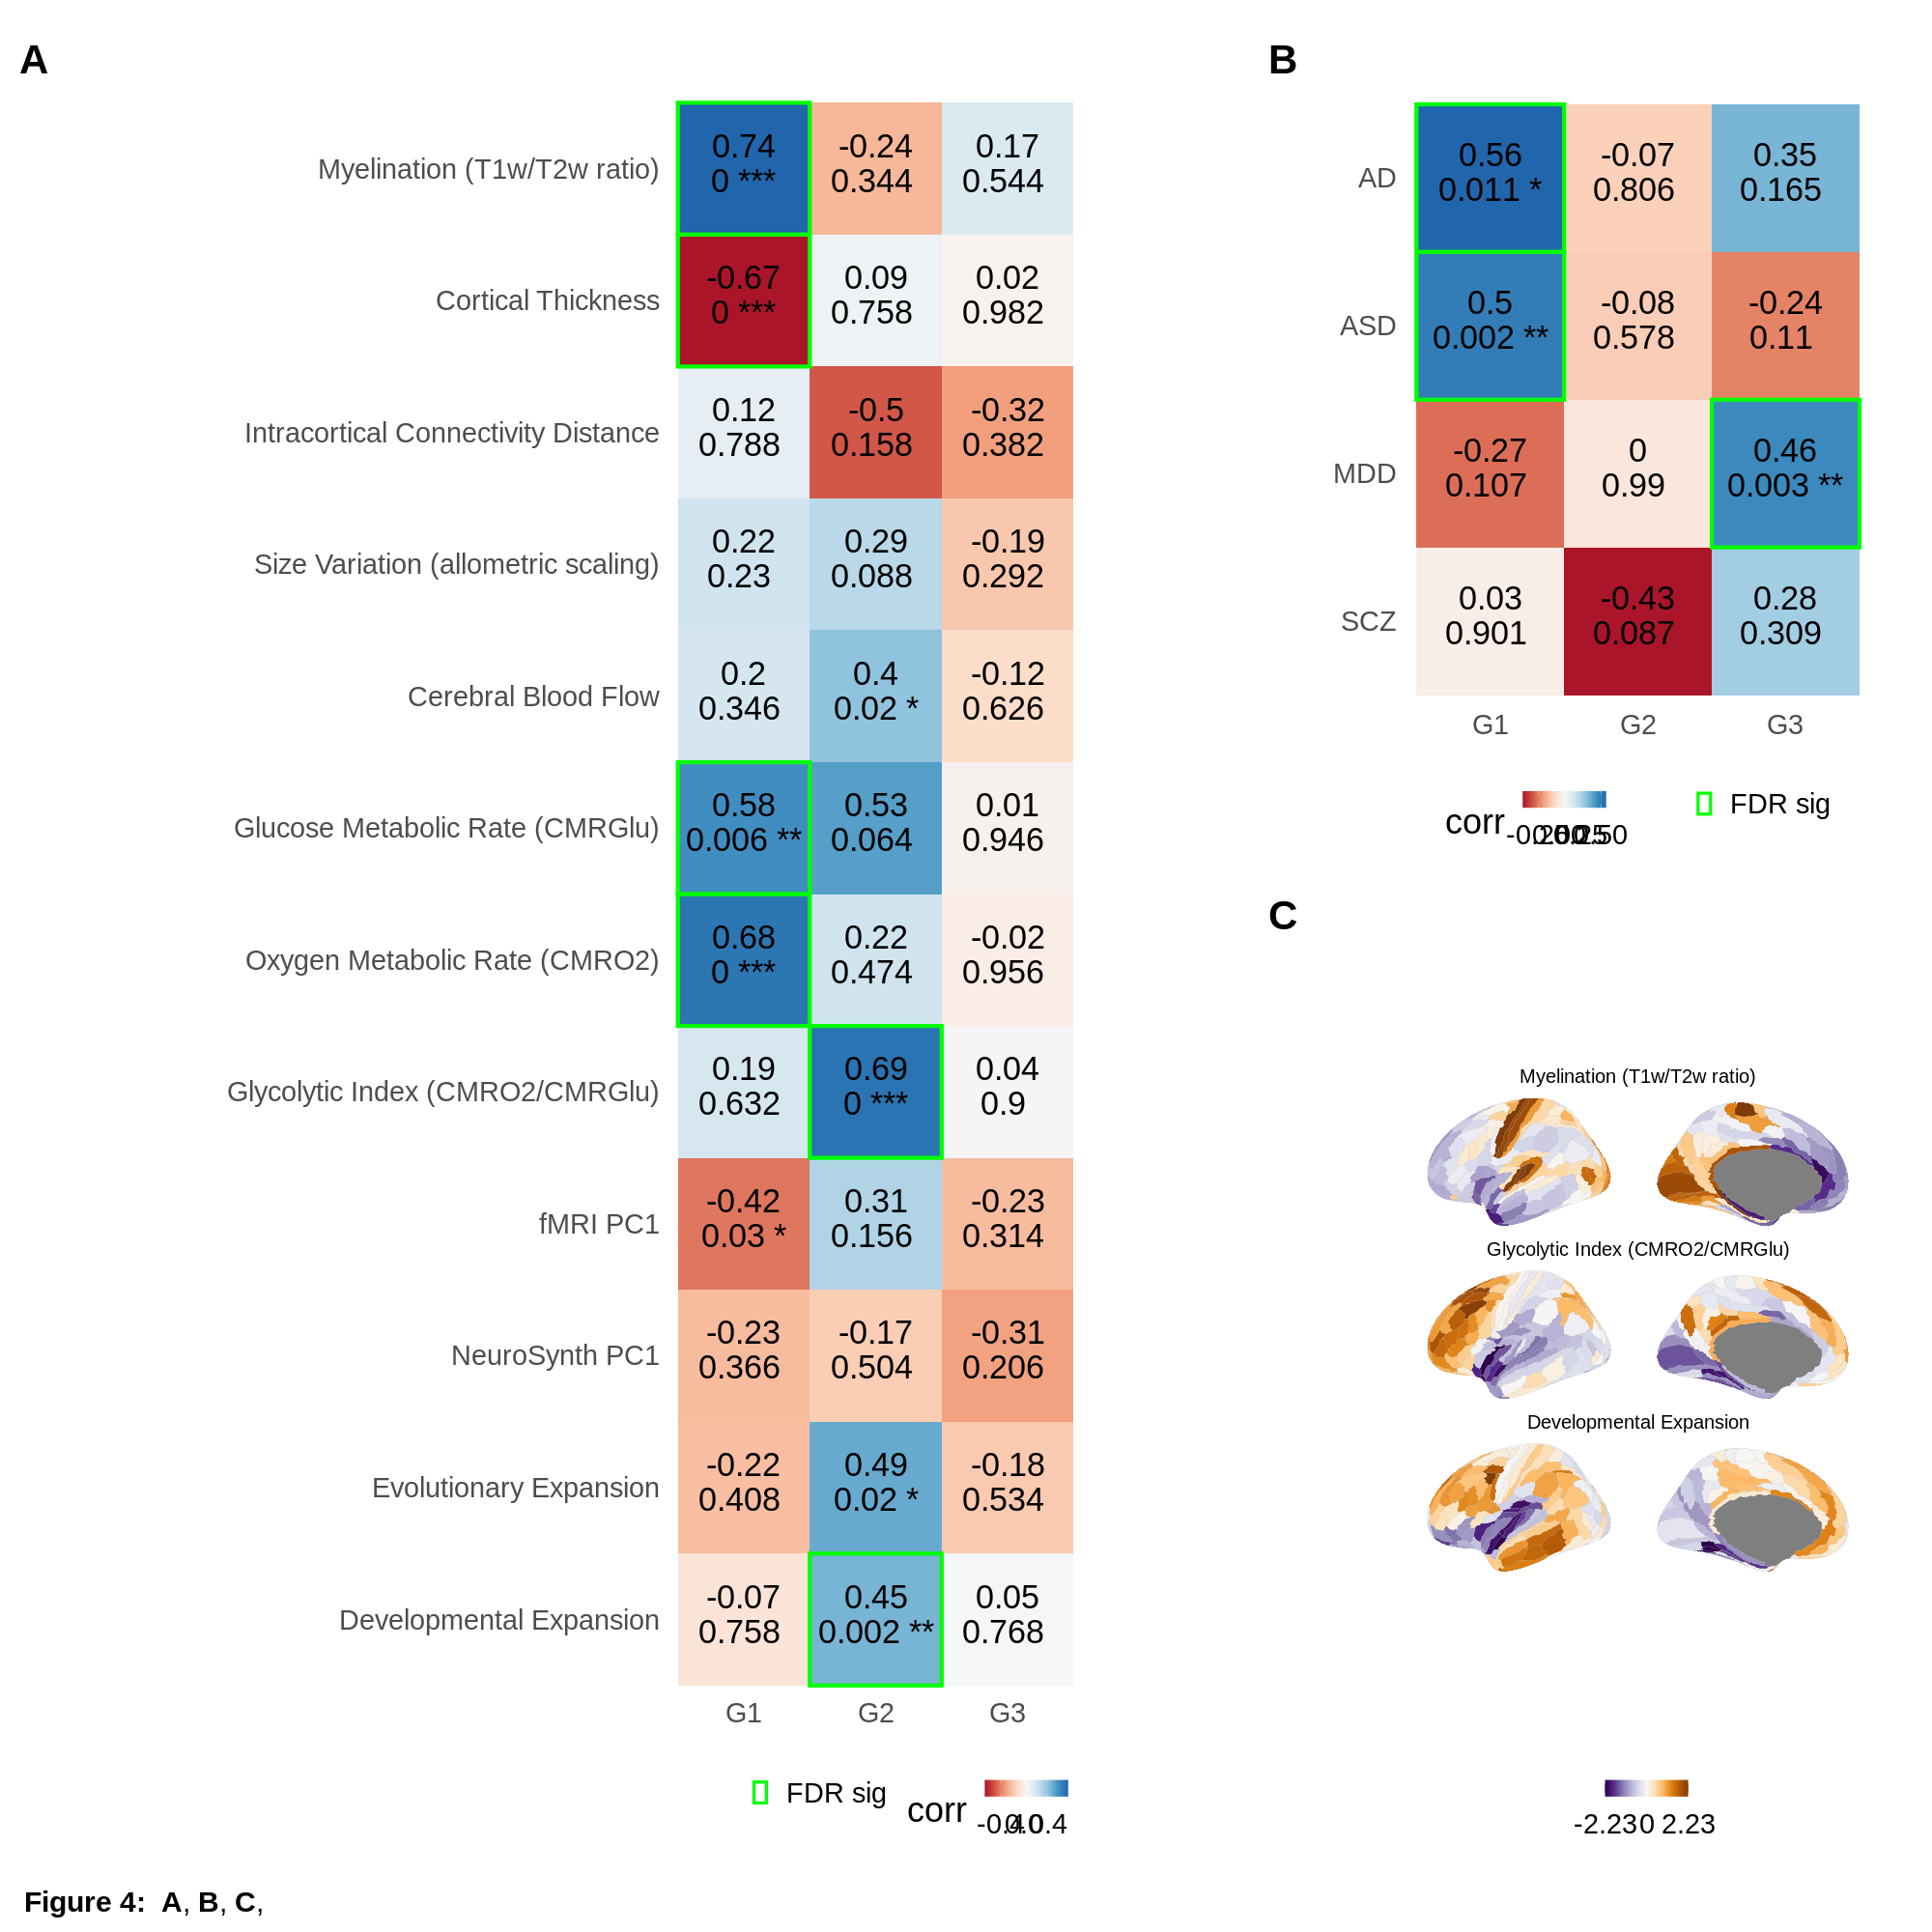

In [191]:
%%R -i mri_corrs -i disorder_corrs -i hcp_maps -w 2000 -h 2000
source("../code/plot_maps.R")
g1 <- plot_corr_versions(mri_corrs, size=12)
g2 <- plot_corr_versions(disorder_corrs, size=12)
g3 <- plot_maps(hcp_maps, ncol=1, colors=rev(brewer.puor(100)))

plot <- (
    g1 | 
    (g2 / g3)
) + plot_layout(widths=c(3,2))

themed <- plot & theme(
    text=element_text(size=36),
    plot.margin = margin(t=10, r=30, b=10, l=10, "pt"),
    plot.tag = element_text(size=42, face='bold', vjust=-2)
)

caption <- paste("**Figure 4:**",
                "**A**, ",
                "**B**, ",
                "**C**, "
)

annotated <- themed + plot_annotation(
  tag_level='A',
  caption = caption,
  theme = theme(plot.caption = element_textbox_simple(size = 30, padding = unit(c(40, 5, 5, 5), "pt")))
)
annotated